**COMPUTE ANGULAR POWER SPECTRA $C_\ell$ FOR QUAIA AND CATWISE**

1. Use my own functions to compute the linear least-squares fit of the CatWISE2020/S21 overdensities to $Y_{\ell m}$ templates, up to some max $\ell$, where the overdensity is defined as
$$
\delta_{g,p} = \frac{N_p}{\langle N_p\rangle}
$$
where $N_p$ is the number of quasars in healpixel $p$. The denominator is the mean density of the _expected_ map.


2. Compare the CatWISE $C_\ell$ results to Quaia (where we use the selection function in the fit)


3. Compare the above two results to the theory prediction (from Giulio and David)


4. Compare $\ell_\mathrm{max}$ used in the fit


5. Get shot noise estimate, to subtract from the measured $C_\ell$ to better compare to theory

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### ** fitting function **

In [3]:
def Cells_from_alms_fit(datamap, Cinv, max_ell, idx_to_fit=None):
    """
    Performs a linear least-squares fit to a healpix density map to get best-fit spherical harmonic amplitudes alm.
    Regularize by setting masked pixels (NaN or hp.UNSEEN) to zero counts and assuming `Cinv=1`.
    Returns the Cells as computed from the alms (sum of |alms|^2).
    
    """
    assert datamap.shape == Cinv.shape
    assert datamap.ndim == Cinv.ndim == 1
    
    # get number of pixels from input data map
    NPIX = len(datamap)
    
    # construct Ylm templates -> design matrix
    ells = np.arange(0, max_ell+1)
    templates = construct_templates(ells, hp.npix2nside(NPIX))
    A = templates.T
    
    # indices to fit: non-NaN, non-hp.UNSEEN, non-zero
    if idx_to_fit is None:
        idx_to_fit = np.full(NPIX, True).astype(bool)
    else:
        idx_to_fit = idx_to_fit
    idx_to_fit = idx_to_fit & (datamap != 0) & (~np.isnan(datamap)) & (datamap != hp.UNSEEN)
    map_to_fit, A_fit, Cinv_fit = datamap.copy(), A.copy(), Cinv.copy()
    
    # regularization: set masked data to 0 and variance in masked pixels to 1
    map_to_fit[~idx_to_fit] = 0
    Cinv_fit[~idx_to_fit] = 1.
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
    Cells = compute_Cells(bestfit_pars)
    
    return ells, Cells

### load CatWISE sample

In [4]:
# load astropy Table and convert into healpix map

NSIDE = 64  # healpix resolution

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, save_tag='_r1.0', load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


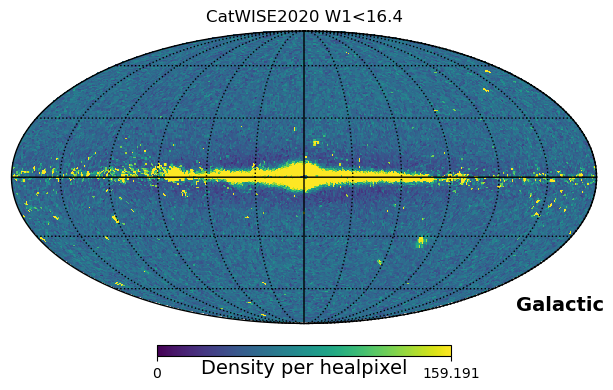

In [5]:
# plot the data
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], badcolor='white')
hp.mollview(datamap, title=f'CatWISE2020 W1<{d.maglim}', sub=(1,2,1), unit='Density per healpixel',
            min=max(mean-2*std,0), max=mean+2*std, **kwargs)

hp.graticule()

In [6]:
# mask the data: galactic plane and smaller masks

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

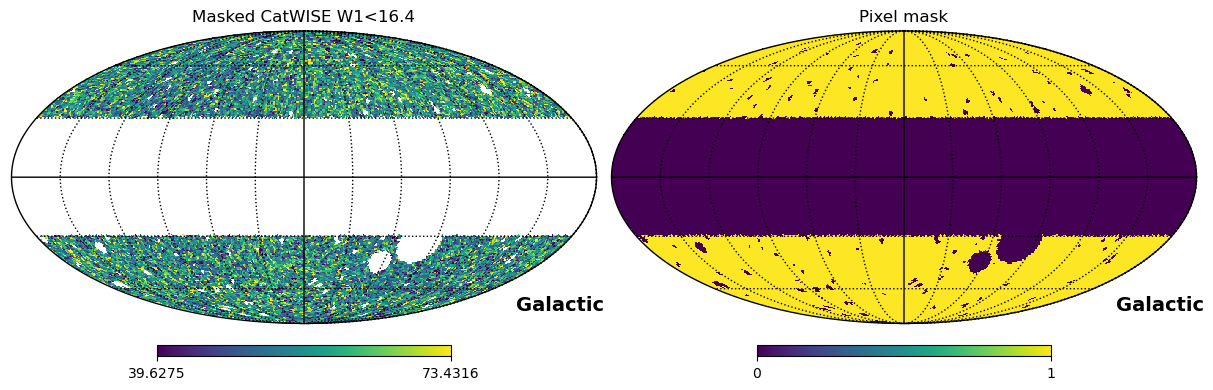

In [7]:
# plot the masked data map and the pixel mask
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.mollview(masked_datamap, title=f'Masked CatWISE W1<{d.maglim}', min=max(mean-2*std,0), max=mean+2*std,
            sub=(1,2,1), **kwargs)
hp.mollview(mask, title='Pixel mask', sub=(1,2,2), **kwargs)
hp.graticule()

In [8]:
# GET OVERDENSITIES
overdensity_map_catwise = masked_datamap / np.nanmean(masked_datamap) - 1

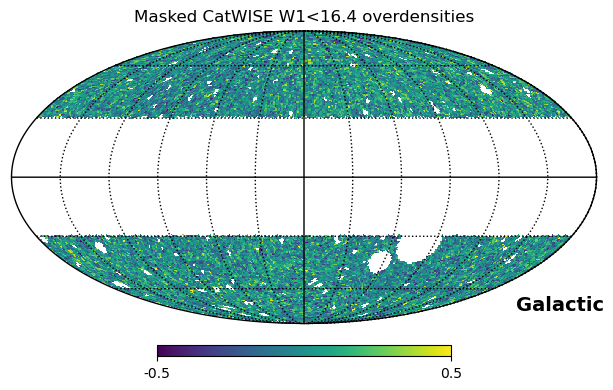

In [9]:
# plot the overdensity map
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(overdensity_map_catwise, title=f'Masked CatWISE W1<{d.maglim} overdensities',
            min=-.5, max=.5, sub=(1,2,1), **kwargs)
hp.graticule()

In [10]:
# are we symmetric about zero?
np.nanmean(overdensity_map_catwise)

-1.1760956919889613e-17

### FIT $a_{\ell m}$, setting masked pixels to zero in the fit

In [39]:
# choose a max_ell
max_ell = 10

# covariances for the fit:
#  since we have no selection function for CatWISE, assume all unmasked pixels have completeness 1
Cinv = np.ones(hp.nside2npix(NSIDE))

# perform the regression and return the Cells
ells, Cells_catwise = Cells_from_alms_fit(overdensity_map_catwise, Cinv, max_ell)

## Quaia

In [40]:
# load astropy Table and convert into healpix map

# NSIDE defined above with CatWISE

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


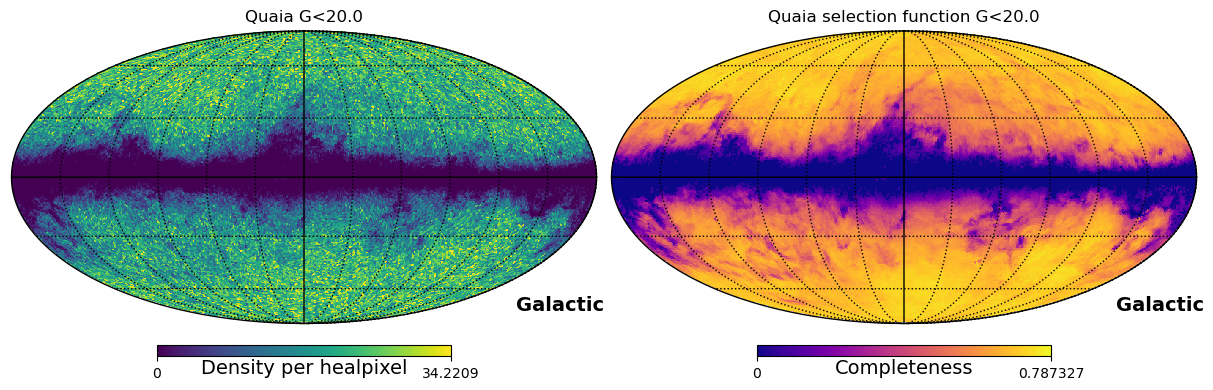

In [41]:
# plot these two
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], badcolor='white')
hp.mollview(datamap, title=f'Quaia G<{d.maglim}', sub=(1,2,1), unit='Density per healpixel',
            min=max(mean-2*std,0), max=mean+2*std, **kwargs)
hp.mollview(selfunc, title=f'Quaia selection function G<{d.maglim}', sub=(1,2,2), unit='Completeness',
            cmap='plasma', **kwargs)
hp.graticule()

In [42]:
# mask the data: galactic plane and smaller masks

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

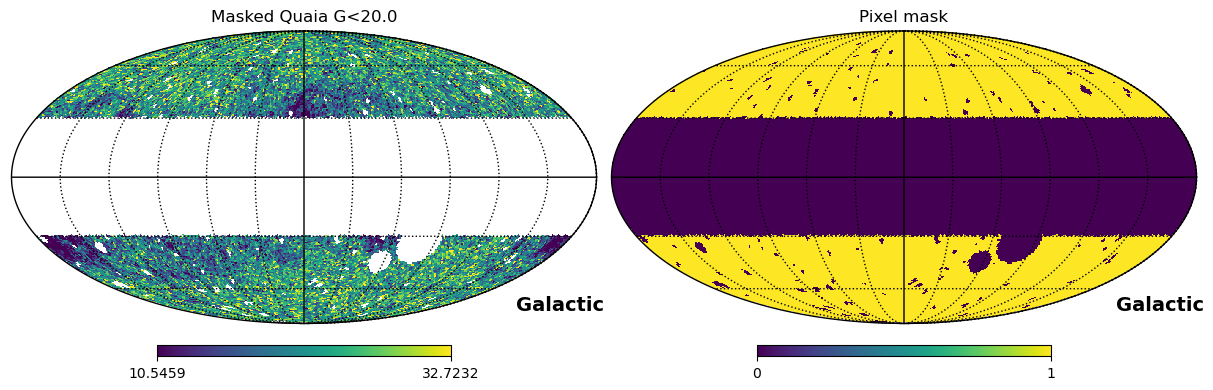

In [43]:
# plot the masked data map and the pixel mask
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.mollview(masked_datamap, title=f'Masked Quaia G<{d.maglim}', min=max(mean-2*std,0), max=mean+2*std,
            sub=(1,2,1), **kwargs)
hp.mollview(mask, title='Pixel mask', sub=(1,2,2), **kwargs)
hp.graticule()

In [44]:
# GET OVERDENSITIES

# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap[selfunc>0] / selfunc[selfunc>0])

# then the overdensity map is
overdensity_map_quaia = np.divide(masked_datamap, selfunc, where=(selfunc>0),
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                    # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

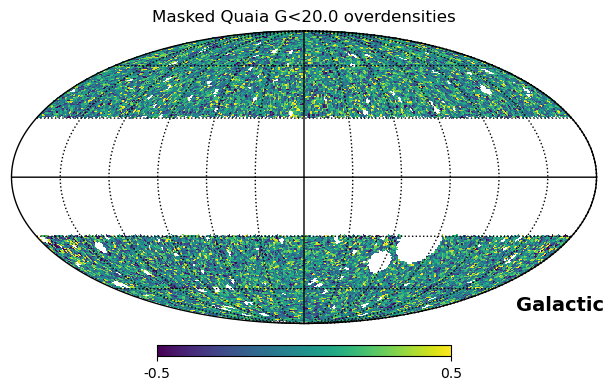

In [45]:
# plot the overdensity map
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(overdensity_map_quaia, title=f'Masked Quaia G<{d.maglim} overdensities',
            min=-.5, max=.5, sub=(1,2,1), **kwargs)
hp.graticule()

In [46]:
# PERFORM THE FIT
# (max_ell defined above, with CatWISE)

# covariances for the fit: the selection function
Cinv = selfunc

# perform the regression
ells, Cells_quaia = Cells_from_alms_fit(overdensity_map_quaia, Cinv, max_ell)

# ALSO fit only where completeness >= 0.5
ells, Cells_quaia_clean = Cells_from_alms_fit(overdensity_map_quaia, Cinv, max_ell, idx_to_fit=(selfunc >= 0.5))

### compare Quaia and CatWISE to CMB expectation

In [47]:
# EXPECTATION FROM CMB

# !!! normalization issue !!! amplitudes are almost definitely incorrect

# CMB dipole direction, and expected amplitudes for each sample from EB84
_, cmb_dipdir = dipole.cmb_dipole()
cmb_dipamp_catwise = 0.007
cmb_dipamp_quaia = 0.005

# convert (l,b) to a 3D vector on the sky
vec_qso  = hp.ang2vec(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, lonlat=True)
# vector for every healpixel on the sky
vecs = hp.pix2vec(NSIDE, np.arange(hp.nside2npix(NSIDE))) # NSIDE defined at beginning of notebook

# cosine between every healpixel and the dipole peak
costheta = np.dot(np.array(vecs).T, vec_qso)

# the expected dipole
dipole_qso_catwise = cmb_dipamp_catwise * costheta
dipole_qso_quaia = cmb_dipamp_quaia * costheta
# the expected quadrupole
quadrupole_qso_catwise = cmb_dipamp_catwise**2 * 3 * (3 * costheta**2 - 1) / 2
quadrupole_qso_quaia = cmb_dipamp_quaia**2 * 3 * (3 * costheta**2 - 1) / 2

# Cells of the combined map, only up to the quadrupole
Cells_exp_catwise = hp.anafast(dipole_qso_catwise + quadrupole_qso_catwise, lmax=2)
Cells_exp_quaia = hp.anafast(dipole_qso_quaia + quadrupole_qso_quaia, lmax=2)

In [48]:
# load in best-fit model from David
with np.load('/scratch/aew492/quasars/quaia_PS/cl_gg_bf_G20.0_1bin.npz') as res:
    ell = res['ell']
    cl_gg = res['cl_gg']

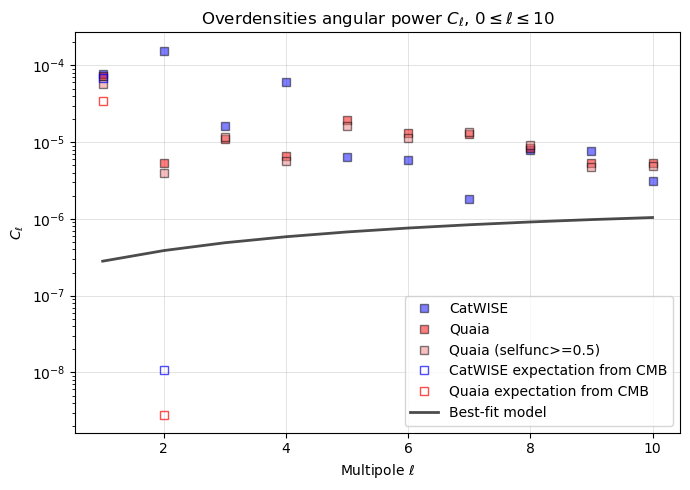

In [49]:
# compare the various Cell results
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', alpha=0.5, mec='k')
ax.plot(ells[1:], Cells_catwise[1:], c='b', label='CatWISE', **kwargs)
ax.plot(ells[1:], Cells_quaia[1:], c='r', label='Quaia', **kwargs)
ax.plot(ells[1:], Cells_quaia_clean[1:], c='lightcoral', label='Quaia (selfunc>=0.5)', **kwargs)
ax.plot([1,2], Cells_exp_catwise[1:], c='None', mec='b', alpha=0.7, ls='None', marker='s',
        label='CatWISE expectation from CMB')
ax.plot([1,2], Cells_exp_quaia[1:], c='None', mec='r', alpha=0.7, ls='None', marker='s',
        label='Quaia expectation from CMB')
idx = (ell <= max_ell)
ax.plot(ell[idx], cl_gg[idx], c='k', alpha=0.7, lw=2, label='Best-fit model')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### ONLY fit the dipole, with our usual (same as S21) dipole amplitude definition

how does fitting zeros impact the fit?? we've been using `fit_zeros=False`, but setting all masked pixels to zero and using `fit_zeros=True` implements the regularization we're now using in the $C_\ell$ fit

In [50]:
# CatWISE: Cinv=identity, fit_zeros=False
map_to_fit = overdensity_map_catwise.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=None, fit_zeros=False)
print(f"amps: {amps}\nbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"expected dipole amp. =\t{cmb_dipamp_catwise:.5f}\nratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_catwise:.4f}")

amps: [ 7.70097306e-05 -1.24867252e-02  1.04018103e-02 -4.40991047e-03]
best-fit dipole amp. =	0.01684
expected dipole amp. =	0.00700
ratio =			2.4056


In [51]:
# best-fit dipole amp. is slightly different than the fiducial value quoted in the Overleaf (0.015) because I'm
#   not using the exact same sample from S21
#   (not doing here the extra steps like elat density corr. and identical masking)

In [52]:
# CatWISE: Cinv=identity, fit_zeros=True
map_to_fit = overdensity_map_catwise.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=None, fit_zeros=True)
print(f"amps: {amps}\nbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"expected dipole amp. =\t{cmb_dipamp_catwise:.5f}\nratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_catwise:.4f}")

amps: [-4.35851430e-18 -7.04874000e-03  2.39939411e-03  4.78969857e-04]
best-fit dipole amp. =	0.00746
expected dipole amp. =	0.00700
ratio =			1.0659


In [53]:
# Quaia: Cinv=selfunc, fit_zeros=False
map_to_fit = overdensity_map_quaia.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=selfunc, fit_zeros=False)
print(f"amps: {amps}\nbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"expected dipole amp. =\t{cmb_dipamp_quaia:.5f}\nratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")

amps: [-0.00016737 -0.01116305 -0.00656966 -0.008234  ]
best-fit dipole amp. =	0.01535
expected dipole amp. =	0.00500
ratio =			3.0697


In [54]:
# Quaia: Cinv=(selfunc in unmasked, 1 in masked), fit_zeros=True
map_to_fit = overdensity_map_quaia.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
Cinv = selfunc.copy()
Cinv[np.isnan(map_to_fit)] = 1
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=True)
print(f"amps: {amps}\nbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"expected dipole amp. =\t{cmb_dipamp_quaia:.5f}\nratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")

amps: [-0.0001208  -0.00790568 -0.00432193 -0.00286323]
best-fit dipole amp. =	0.00945
expected dipole amp. =	0.00500
ratio =			1.8908


### compare max ell

In [27]:
# max ells to try
max_ells = [1,2,10]

In [28]:
ellss = []
Cells_catwises = []
Cells_quaias = []
for i, max_ell in enumerate(max_ells):
    # CATWISE
    # covariances for the fit
    Cinv = np.ones(hp.nside2npix(NSIDE))
    # perform the regression and return the Cells
    ells_, Cells_catwise_ = Cells_from_alms_fit(overdensity_map_catwise, Cinv, max_ell)
    
    # QUAIA
    # covariances for the fit: the selection function
    Cinv = selfunc
    # perform the regression
    ells_, Cells_quaia_ = Cells_from_alms_fit(overdensity_map_quaia, Cinv, max_ell)
    
    ellss.append(ells_)
    Cells_catwises.append(Cells_catwise_)
    Cells_quaias.append(Cells_quaia_)

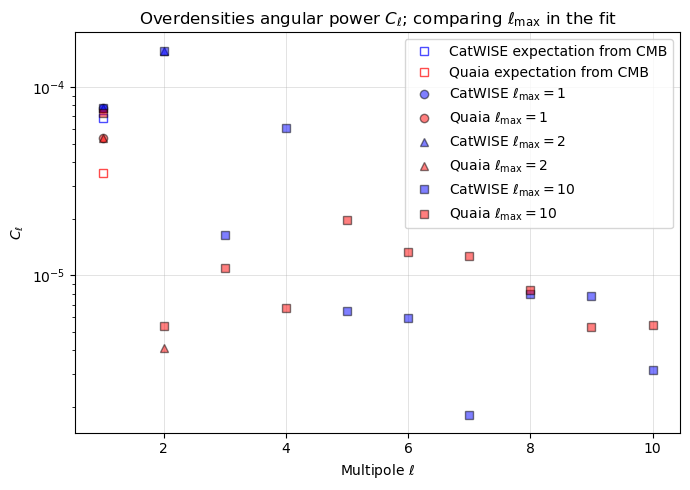

In [29]:
# compare these results with different max ells
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', alpha=0.5, mec='k')
markers = ['o','^','s']
ax.plot([1], Cells_exp_catwise[1], c='None', mec='b', alpha=0.7, ls='None', marker='s',
        label='CatWISE expectation from CMB')
ax.plot([1], Cells_exp_quaia[1], c='None', mec='r', alpha=0.7, ls='None', marker='s',
        label='Quaia expectation from CMB')
for i, max_ell in enumerate(max_ells):
    ax.plot(ellss[i][1:], Cells_catwises[i][1:], c='b', marker=markers[i],
            label=r'CatWISE $\ell_\mathrm{max}=$'f'{max_ell}', **kwargs)
    ax.plot(ellss[i][1:], Cells_quaias[i][1:], c='r', marker=markers[i],
            label=r'Quaia $\ell_\mathrm{max}=$'f'{max_ell}', **kwargs)
    ax.semilogy()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(r'$C_\ell$')
    ax.set_title(r'Overdensities angular power $C_\ell$; comparing $\ell_\mathrm{max}$ in the fit')
    ax.legend()

### shot noise term

In [55]:
# estimate shot noise from the correlations sent by Giulio

# load dictionaries: compare the different results
res = np.load(f'/scratch/aew492/quasars/quaia_PS/G20.0_selfunc50_remove_dipole_True.pkl', allow_pickle=True)
res_linsyst = np.load(f'/scratch/aew492/quasars/quaia_PS/G20.0_selfunc50_remove_dipole_True_linsyst_alltemplates.pkl', allow_pickle=True)
res_205 = np.load(f'/scratch/aew492/quasars/quaia_PS/G20.5_selfunc50_remove_dipole_True.pkl', allow_pickle=True)

Text(0.5, 1.0, 'Quaia G<20.0 shot noise estimates')

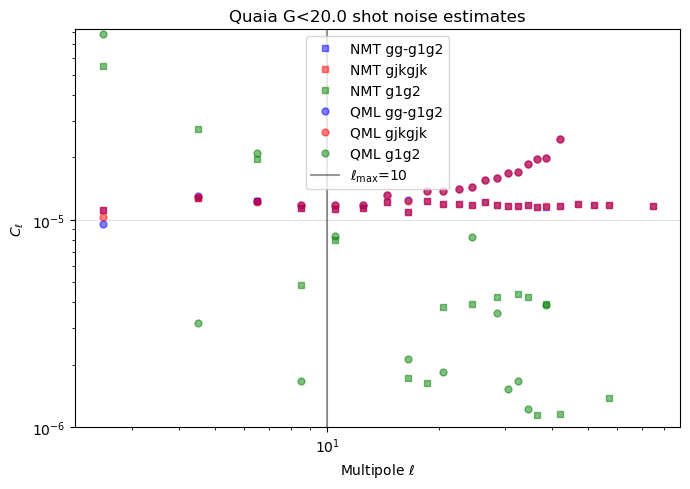

In [56]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

# unpack NMT results on data, auto power (g_sel,g_sel) and the split (g1_sel,g2_sel)
data_res = res['nmt']['diagk_corrg']['data']
gg = data_res[('g_sel','g_sel')]
g1g2 = data_res[('g1_sel','g2_sel')]
gjkgjk = data_res[('gjk_sel','gjk_sel')]
ell = res['nmt']['lb']

kwargs = dict(marker='s', alpha=0.5, ms=5, ls='None')
idx = (ell < 100)
ax.plot(ell[idx], gg[idx]-g1g2[idx], c='b', label='NMT gg-g1g2', **kwargs)
ax.plot(ell[idx], gjkgjk[idx], c='r', label='NMT gjkgjk', **kwargs)
ax.plot(ell[idx], g1g2[idx], c='g', label='NMT g1g2', **kwargs)

# unpack QML results on data, auto power (g_sel,g_sel) and the split (g1_sel,g2_sel)
data_res = res['qml']['diagk_corrg']['data']
gg = data_res[('g_sel','g_sel')]
g1g2 = data_res[('g1_sel','g2_sel')]
gjkgjk = data_res[('gjk_sel','gjk_sel')]
ell = res['qml']['lb']

kwargs = dict(marker='o', alpha=0.5, ms=5, ls='None')
idx = (ell < 100)
ax.plot(ell[idx], gg[idx]-g1g2[idx], c='b', label='QML gg-g1g2', **kwargs)
ax.plot(ell[idx], gjkgjk[idx], c='r', label='QML gjkgjk', **kwargs)
ax.plot(ell[idx], g1g2[idx], c='g', label='QML g1g2', **kwargs)

ax.axvline(max_ell, c='k', alpha=0.4, ls='-', label=r'$\ell_\mathrm{max}$='f'{max_ell}')
ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(1e-6,None)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.loglog()
ax.legend()
ax.set_title(r'Quaia G<20.0 shot noise estimates')

In [57]:
# start by taking average of the NMT shot noise from ell=0 to max_ell,
#  but maybe we want to interpolate in some way to capture the dependence of shot noise on ell ?
data_res = res['nmt']['diagk_corrg']['data']
gjkgjk = data_res[('gjk_sel','gjk_sel')]
ell = res['nmt']['lb']
noise = np.mean(gjkgjk[ell<=max_ell])
noise

1.1924599981309956e-05

In [58]:
# load in best-fit model from David
with np.load('/scratch/aew492/quasars/quaia_PS/cl_gg_bf_G20.0_1bin.npz') as res_david:
    ell = res_david['ell']
    cl_gg = res_david['cl_gg']

In [59]:
ell.shape, cl_gg.shape

((96,), (96,))

In [60]:
res['nmt']['lb'].shape, g1g2.shape

((47,), (20,))

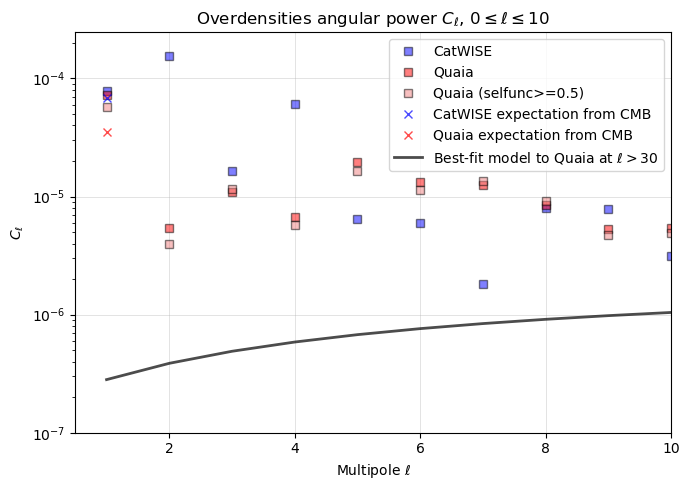

In [61]:
# compare the various Cell results
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', alpha=0.5, mec='k')
ax.plot(ells[1:], Cells_catwise[1:], c='b', label='CatWISE', **kwargs)
ax.plot(ells[1:], Cells_quaia[1:], c='r', label='Quaia', **kwargs)
ax.plot(ells[1:], Cells_quaia_clean[1:], c='lightcoral', label='Quaia (selfunc>=0.5)', **kwargs)
ax.plot([1], Cells_exp_catwise[1], c='None', mec='b', alpha=0.7, ls='None', marker='x',
        label='CatWISE expectation from CMB')
ax.plot([1], Cells_exp_quaia[1], c='None', mec='r', alpha=0.7, ls='None', marker='x',
        label='Quaia expectation from CMB')
# ax.plot(res['nmt']['lb'], g1g2, c='k', label='QML g1g2', **kwargs)
ax.plot(ell, cl_gg, c='k', alpha=0.7, lw=2, label=r'Best-fit model to Quaia at $\ell>30$')
ax.semilogy()
ax.set_xlim(0.5, 10)
ax.set_ylim(1e-7,None)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

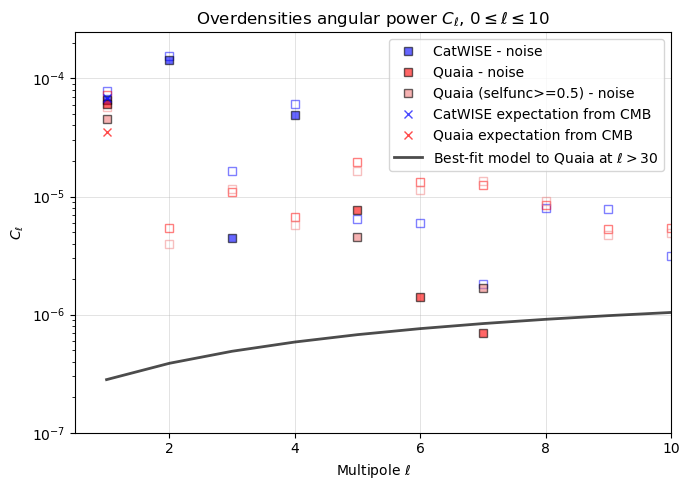

In [62]:
# compare the various Cell results
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', alpha=0.6, mec='k')
ax.plot(ells[1:], Cells_catwise[1:], mec='b', mfc='None', marker='s', ls='None', alpha=0.5)
ax.plot(ells[1:], Cells_quaia[1:], mec='r', mfc='None', marker='s', ls='None', alpha=0.5)
ax.plot(ells[1:], Cells_quaia_clean[1:], mec='lightcoral', mfc='None', marker='s', ls='None', alpha=0.5)
ax.plot(ells[1:], Cells_catwise[1:]-noise, c='b', label='CatWISE - noise', **kwargs)
ax.plot(ells[1:], Cells_quaia[1:]-noise, c='r', label='Quaia - noise', **kwargs)
ax.plot(ells[1:], Cells_quaia_clean[1:]-noise, c='lightcoral', label='Quaia (selfunc>=0.5) - noise', **kwargs)
ax.plot([1], Cells_exp_catwise[1], c='None', mec='b', alpha=0.7, ls='None', marker='x',
        label='CatWISE expectation from CMB')
ax.plot([1], Cells_exp_quaia[1], c='None', mec='r', alpha=0.7, ls='None', marker='x',
        label='Quaia expectation from CMB')
# ax.plot(res['nmt']['lb'], g1g2, c='k', label='QML g1g2', **kwargs)
ax.plot(ell, cl_gg, c='k', alpha=0.7, lw=2, label=r'Best-fit model to Quaia at $\ell>30$')
ax.semilogy()
ax.set_xlim(0.5, 10)
ax.set_ylim(1e-7,None)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

In [40]:
# okay so several Cells actually go negative...